In [1]:
from IPython.display import Image
Image(url="https://www.cntk.ai/jup/cancer_data_plot.jpg", width=400, height=400 )

## GOAL

Learn a classifier that can automatically label any patient into either the benign or malignant categories given two features: age & tumor size.

We need to create a **linear classifier**, which is a fundamental building-block in deep networks.

In [2]:
Image(url="https://www.cntk.ai/jup/cancer_classify_plot.jpg", width=400, height=400)

We'll want to make a classifier which matches the green line and separates the blue dots from the red.

## Five Stages

1. **Data Reading:** Generate simulated data sets. Each sample will have two features: *age* & *tumor size*
2. **Data Preprocessing:** Individual features may need to be scaled, between 0--1
3. **Model Creation:** Linear model
4. **Learning the model:** *Training*. Ex: linear regression, Stochastic Gradient Descent. 
5. **Evaluation:** *Testing*, where you evaluate the model on data sets with known labels which were not used with training. 

In [3]:
from __future__ import print_function
import numpy as np
import sys
import os

import cntk as C

# Check to see if running on a GPU
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(C.device.cpu())
    else:
        C.device.try_set_default_device(C.device.gpu(0))
        
# Check for CNTK version
if not C.__version__== "2.0":
    raise Exception("this notebook was designed to work with 2.0. Current Version: " + C.__version__) 

In [4]:
# Define the network
input_dim          = 2
num_output_classes = 2 

In [5]:
# Generate data from numpy. 
# Makes the random numbers predictable. Same ran numbers appear with each seed.
# EX: array([ 0.55,  0.72,  0.6 ,  0.54])
np.random.seed(0)

# Helper func to generate a random data sample
def generate_random_data_sample(sample_size, feature_dim, num_classes):
    # Create synthetic data from NumPy
    Y = np.random.randint(size=(sample_size, 1), low=0, high=num_classes)
    
    # Make sure that data is seperable.
    # Default type is double. Corce to float.
    X = (np.random.randn(sample_size, feature_dim)+3) * (Y+1)
    X = X.astype(np.float32)
    print(X)
    
    # convert class 0 into the vector "1 0 0", 
    # class 1 into the vector "0 1 0", ...
    class_ind = [Y==class_number for class_number in range(num_classes)]
    
    # Stack arrays in sequence horizontally (column wise).
    Y         = np.asarray(np.hstack(class_ind), dtype=np.float32)
    print(Y)
    
    return X,Y

In [6]:
# Creating input vars for features and labal data
mysamplesize     = 32
features, labels = generate_random_data_sample(mysamplesize, input_dim, num_output_classes) 

[[  3.44386315   3.33367443]
 [  8.98815823   5.58968353]
 [  6.62613535   4.29180861]
 [  0.44701019   3.65361857]
 [  7.7288723    4.51566982]
 [ 10.53950882   3.09126854]
 [  6.09151697   5.62563229]
 [  9.06555843   8.93871784]
 [  6.30989504   6.75632524]
 [  4.22442865   2.03840709]
 [  5.30417585   6.31269789]
 [  4.23029089   4.2023797 ]
 [  2.61267328   2.69769716]
 [  3.90289402   3.15996408]
 [  1.29372978   4.95077562]
 [  2.49034786   2.56192565]
 [  1.74720466   3.77749038]
 [  1.3861022    2.78725982]
 [  2.10453343   3.38690257]
 [  4.97838974   3.63873553]
 [  2.97181773   3.42833185]
 [  6.13303423   6.60494375]
 [  4.73135567   5.27451754]
 [  2.32753944   2.6404469 ]
 [  2.18685365   1.2737174 ]
 [  6.3548522    5.19643831]
 [  2.73960328   6.92556429]
 [  4.18540335   6.1038909 ]
 [  7.4581809    6.25796604]
 [  4.13940048   1.76517415]
 [  6.80468321   4.63037968]
 [  2.12920284   2.42115045]]
[[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.

In [7]:
# Plotting the data
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
# 0: red | maglignant
# 1: blue | benign
colors = ['r' if label == 0 else 'b' for label in labels[:,0]]

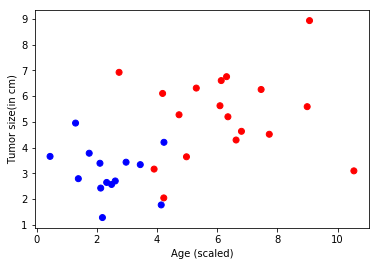

In [12]:
plt.scatter(features[:,0], features[:,1], c=colors)
plt.xlabel("Age (scaled)")
plt.ylabel("Tumor size(in cm)")
plt.show()

## Model Creation
Take a vector of numbers decsribiing properties of what we are classifying (features), and emits evidence (activation).

In [13]:
feature = C.input_variable(input_dim, np.float32)

In [14]:
# Dict to store model params
mydict = {}

def linear_layer(input_var, output_dim):
    
    input_dim    = input_var.shape[0]
    weight_param = C.parameter(shape=(input_dim, output_dim))
    bias_param   = C.parameter(shape=(output_dim))
    
    mydict['w'], mydict['b'] = weight_param, bias_param
    
    return C.times(input_var, weight_param) + bias_param

In [15]:
output_dim = num_output_classes
z          = linear_layer(feature, output_dim)

In [18]:
# Convert computed evidence (z) into a set of predicted probabilities (p) using softmax.
# Cost/loss function: minimize the diff b/t our putput and the ground-truth labels.
# Cross Entropy     : Popular loss function
label = C.input_variable(num_output_classes, np.float32)
loss  = C.cross_entropy_with_softmax(z, label)

In [19]:
# 0 if our model was correct, otherwise 1
eval_error = C.classification_error(z, label)

In [21]:
# SGD for optimization technique
# Can calc the loss or error b/t predictived val and ground-truth
# Instantiate the trainer object to drive the model training
learning_rate = 0.5
lr_schedule   = C.learning_rate_schedule(learning_rate, C.UnitType.minibatch) 
learner       = C.sgd(z.parameters, lr_schedule)
trainer       = C.Trainer(z, (loss, eval_error), [learner])

In [25]:
def moving_average(a, w=10):
    if len(a) < w: 
        return a[:]    
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Define a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
  Ctraining_loss, eval_error = "NA", "NA"

  if mb % frequency == 0:
    training_loss = trainer.previous_minibatch_loss_average
    eval_error = trainer.previous_minibatch_evaluation_average
    if verbose: 
        print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}".format(mb, training_loss, eval_error))

    return mb, training_loss, eval_error

In [26]:
# Training
minibatch_size           = 25
num_samples_to_train     = 20000
num_minibatches_to_train = int(num_samples_to_train / minibatch_size)

In [30]:
# High-performance container datatypes
from collections import defaultdict

# Run the trainer and perform model training
training_progress_output_freq = 50
plotdata                      = defaultdict(list)

for i in range(0, num_minibatches_to_train):
    features, labels = generate_random_data_sample(minibatch_size, input_dim, num_output_classes)
    
    # Assign the minibatch data to the input variables and train the model on the minibatch
    trainer.train_minibatch({feature : features, label : labels})
    batchsize, loss, error = print_training_progress(trainer, i, 
                                                     training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error =="NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"     ].append(loss)
        plotdata["error"    ].append(error)

[[  3.05222511e+00   1.65842080e+00]
 [  4.38294220e+00   3.38691282e+00]
 [  1.66754687e+00   3.50381756e+00]
 [  8.06583118e+00   5.75555277e+00]
 [  9.66527557e+00   5.86853361e+00]
 [  9.72755337e+00   5.75261831e+00]
 [  4.22039890e+00   2.99341273e+00]
 [  3.59374523e+00   2.33602071e+00]
 [  4.78515434e+00   2.87125945e+00]
 [  1.26625800e+00   2.38443565e+00]
 [  2.04536605e+00   2.75119495e+00]
 [  5.88982487e+00   6.56413984e+00]
 [  1.10568190e+00   3.83831072e+00]
 [  2.58368778e+00   4.35692787e+00]
 [  1.80234051e+00   1.32295430e+00]
 [  8.02246666e+00   4.54374409e+00]
 [  2.78276467e+00   3.53001666e+00]
 [  2.20809364e+00   6.64937067e+00]
 [  2.67232513e+00   3.50306749e+00]
 [  8.01109886e+00   7.14937162e+00]
 [  4.55668020e+00   2.58108163e+00]
 [  5.18056631e+00   8.23274899e+00]
 [  5.49804163e+00   5.16954374e+00]
 [  2.36091375e+00   5.49776745e+00]
 [ -5.12816198e-03   2.12600279e+00]]
[[ 1.  0.]
 [ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0

TypeError: 'NoneType' object is not iterable

In [31]:
# Compute the moving avg loss to smooth noise in SGD


TypeError: 'collections.defaultdict' object is not callable